In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import KFold, train_test_split

from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.feature_extraction import DictVectorizer

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error

from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
from xgboost import XGBRegressor

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display
from tqdm import tqdm

%matplotlib inline

In [30]:
def data_preprocession(data, features):
    """
    """
    mask = data.sellingprice > 1
    df = data[mask].copy()
        
    df.dropna(inplace=True)
    features = features.copy()

    df["age"] = pd.to_datetime(df.saledate).apply(lambda x: x.year) - df.year
    features.append("age")
    
    for col in df.select_dtypes(["object"]).columns:
        df[col] = df[col].str.lower().str.replace(" ", "_")
    
    df.sellingprice = np.log1p(df.sellingprice)
        
    return df[features]


def train_linear_model(df, model=None, **kwargs):
    """
    """
    
    numerical_features = df.select_dtypes("number").columns.to_list()
    numerical_features.remove("sellingprice")

    rmse_scores = []
    mape_scores = []
    mae_scores = []

    kfold = KFold(n_splits=5, shuffle=True, random_state=2)

    for idx_train, idx_valid in tqdm(kfold.split(df)):
        
        df_train = df.iloc[idx_train].copy()
        df_train.reset_index(drop=True)
        y_train = df_train.pop("sellingprice")

        df_valid = df.iloc[idx_valid].copy()
        df_valid.reset_index(drop=True)
        y_valid = df_valid.pop("sellingprice")
        
        ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)

        df_train["seller"] = ordinal.fit_transform(df_train["seller"].values.reshape(-1,1))
        df_valid["seller"] = ordinal.transform(df_valid["seller"].values.reshape(-1,1))

        scaler = StandardScaler()

        df_train[numerical_features + ["seller"]] = scaler.fit_transform(df_train[numerical_features + ["seller"]])
        df_valid[numerical_features + ["seller"]] = scaler.transform(df_valid[numerical_features + ["seller"]])

        df_train[numerical_features] = scaler.fit_transform(df_train[numerical_features])
        df_valid[numerical_features] = scaler.transform(df_valid[numerical_features])

        dict_train = df_train.to_dict(orient="records")
        dict_valid = df_valid.to_dict(orient="records")

        
        dv = DictVectorizer(sparse=True)
        X_train = dv.fit_transform(dict_train)
        X_valid = dv.transform(dict_valid)

        regression_model = model(**kwargs)
        
        if model == XGBRegressor:
            fitting_params = {
                "X": X_train,
                "y": y_train,
                "eval_set": [(X_train, y_train), (X_valid, y_valid)]
            }
        else:
            fitting_params = {
                "X": X_train,
                "y": y_train,
            }

        # regression_model.fit(X_train, y_train)
        regression_model.fit(**fitting_params)

        y_valid_predict = regression_model.predict(X_valid)

        rmse = mean_squared_error(y_valid, y_valid_predict, squared=False)
        mape = mean_absolute_percentage_error(y_valid, y_valid_predict)
        mae = mean_absolute_error(y_valid, y_valid_predict)

        rmse_scores.append(rmse)
        mape_scores.append(mape)
        mae_scores.append(mae)

    return kwargs, np.mean(rmse_scores), np.mean(mape_scores), np.mean(mae_scores)


def plot_scores(logs, param_name, tuned_param, ylim=[0.21, 0.24], folds=5, n_estimators=350):
    """
    """
    
    logs_tab = [record.split('\t') for record in logs.split('\n')[:-1]]
    log_scores = []

    for log in logs_tab:
        scores_dict = {}
        scores_dict["n_iter"] = log[0].strip('[]')
        scores_dict["train-rmse"] = float(log[1].split(":")[1])
        scores_dict["valid-rmse"] = float(log[2].split(":")[1])

        log_scores.append(scores_dict)

    scores_df = pd.DataFrame(log_scores)

    scores_dict = {
        p: df
            for p, df in zip(tuned_param, scores_df.values.reshape(-1, 3*n_estimators*folds))
    }

    scores = {}

    for param in scores_dict.keys():

        fold_scores = pd.DataFrame(scores_dict[param].reshape(-1,3), columns=["n_iter", "train-rmse", "valid-rmse"])
        fold_scores["n_iter"] = fold_scores["n_iter"].astype("int")
        
        scores[param] = fold_scores.groupby("n_iter", as_index=False).agg("mean")
    
    
    cmap = plt.get_cmap('plasma')
    colors_grid = np.linspace(0, 1, len(scores.keys()))

    plt.figure(figsize=(12,4))
    for param, color in zip(scores.keys(), cmap(colors_grid)) :
        plt.plot(scores[param]["valid-rmse"].index, scores[param]["valid-rmse"], color=color , label=f"{param_name}={param}")

    plt.ylim(ylim)
    plt.grid()
    plt.legend()
    plt.show()

    return scores


In [18]:
data = pd.read_csv("./dataset/car_prices_full_train.csv", sep=',', header='infer')

features = [
    'year',
    'make',
    'model',
    'trim',
    'body',
    'state',
    'condition',
    'odometer',
    # 'color',
    # 'interior',
    # 'transmission',
    'seller',
    'sellingprice',
    ]

df = data_preprocession(data, features=features)

### Linear Ridge Regression model

In [21]:
alphas = [0.001, 0.01, 0.1, 1, 5, 10, 100]

training_metrics = []
for alpha in tqdm(alphas):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=Ridge, alpha=alpha)
    
    training_metrics.append(scores)


df_metrics = pd.DataFrame(training_metrics)
display(df_metrics.sort_values(by="rmse"))

5it [00:29,  5.99s/it]00:00<?, ?it/s]
5it [00:29,  5.91s/it]00:30<03:00, 30.14s/it]
5it [00:29,  5.88s/it]00:59<02:29, 29.88s/it]
5it [00:29,  5.96s/it]01:29<01:58, 29.73s/it]
5it [00:29,  5.84s/it]01:59<01:29, 29.83s/it]
5it [00:28,  5.68s/it]02:28<00:59, 29.66s/it]
5it [00:27,  5.48s/it]02:57<00:29, 29.27s/it]
100%|██████████| 7/7 [03:24<00:00, 29.26s/it]


,params,rmse,mape,mae
2,{'alpha': 0.1},0.264127,0.020173,0.171922
0,{'alpha': 0.001},0.264445,0.020200,0.172192
1,{'alpha': 0.01},0.264450,0.020201,0.172198
3,{'alpha': 1},0.264598,0.020213,0.172306
4,{'alpha': 5},0.264856,0.020237,0.172535
5,{'alpha': 10},0.266115,0.020348,0.173567
6,{'alpha': 100},0.277743,0.021347,0.182801


In [42]:
# Best Linear Regression Ridge model

alpha = 0.1
model = Ridge

df_full_train = df.copy()
y_full_train = df_full_train.pop("sellingprice")

numerical_features = df_full_train.select_dtypes("number").columns.to_list()

ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)

df_full_train["seller"] = ordinal.fit_transform(df_full_train["seller"].values.reshape(-1,1))

scaler = StandardScaler()

df_full_train[numerical_features + ["seller"]] = scaler.fit_transform(df_full_train[numerical_features + ["seller"]])

dict_full_train = df_full_train.to_dict(orient="records")
               
dv = DictVectorizer(sparse=True)
X_full_train = dv.fit_transform(dict_full_train)

best_lin_reg = model(alpha=alpha)

best_lin_reg.fit(X_full_train, y_full_train)

y_predict = best_lin_reg.predict(X_full_train)

print("Ridge model: RMSE on full_train dataset", mean_squared_error(y_predict, y_full_train, squared=False).round(4))

Ridge model: RMSE on full_train dataset 0.2624


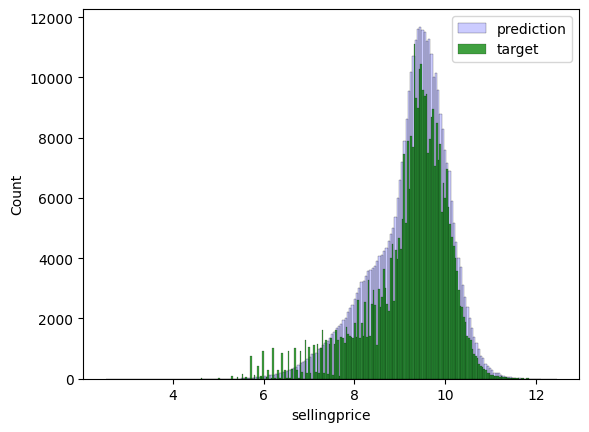

In [23]:
sns.histplot(y_predict, bins=200, color='b', alpha=0.2, label="prediction")
sns.histplot(y_full_train, bins=200, color='g', label="target")

plt.legend()
plt.show()

### XGBoost Regression model

In [26]:
%%capture output

# For faster training i`m using min_child_weight=10

params = {
    "eta": 0.3,
    # "n_estimators": 100,
    "max_depth": 6,
    "min_child_weight": 10,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

n_estimators = [10, 30, 50, 100, 130, 150, 180, 200, 230, 250, 300, 350]

tuned_param = n_estimators

training_metrics = []

for p in tqdm(tuned_param):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=XGBRegressor, n_estimators=p, **params)
    
    training_metrics.append(scores)

In [27]:
# Results of n_estimators tuning n_estimators=350 gives the best performance on cross-validation
# But looks like model still underfitted and more booster rounds can give better result

df_metrics = pd.DataFrame(training_metrics)
display(df_metrics.sort_values(by="rmse"))

,params,rmse,mape,mae
11,"{'n_estimators': 350, 'eta': 0.3, 'max_depth':...",0.214045,0.015831,0.134361
10,"{'n_estimators': 300, 'eta': 0.3, 'max_depth':...",0.216756,0.016123,0.137058
9,"{'n_estimators': 250, 'eta': 0.3, 'max_depth':...",0.220168,0.016481,0.140341
8,"{'n_estimators': 230, 'eta': 0.3, 'max_depth':...",0.221773,0.016657,0.141970
7,"{'n_estimators': 200, 'eta': 0.3, 'max_depth':...",0.224638,0.016960,0.144765
6,"{'n_estimators': 180, 'eta': 0.3, 'max_depth':...",0.227246,0.017219,0.147124
5,"{'n_estimators': 150, 'eta': 0.3, 'max_depth':...",0.231477,0.017660,0.151201
4,"{'n_estimators': 130, 'eta': 0.3, 'max_depth':...",0.235447,0.018045,0.154711
3,"{'n_estimators': 100, 'eta': 0.3, 'max_depth':...",0.244009,0.018898,0.162498
2,"{'n_estimators': 50, 'eta': 0.3, 'max_depth': ...",0.268692,0.021208,0.183551


In [28]:
%%capture output

params = {
    "eta": 0.3,
    "n_estimators": 350,
    # "max_depth": 6,
    "min_child_weight": 10,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

max_depths = [6, 10, 15, 20, 25, 30,]
tuned_param = max_depths

training_metrics = []

for p in tqdm(tuned_param):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=XGBRegressor, max_depth=p, **params)
    
    training_metrics.append(scores)


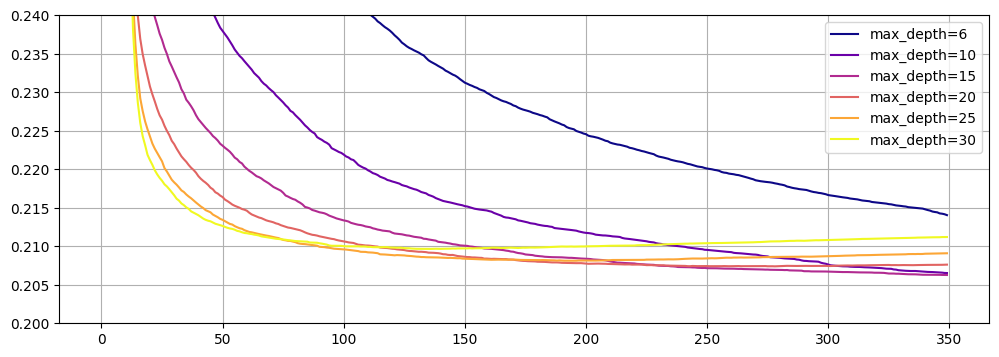

In [32]:
logs = output.stdout
scores_depth = plot_scores(logs, param_name="max_depth", tuned_param=tuned_param, ylim = [0.2, 0.24])

In [34]:
%%capture output

# max_depth between 10 and 15 gives the best performance

params = {
    "eta": 0.3,
    "n_estimators": 350,
    # "max_depth": 6,
    "min_child_weight": 10,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

max_depths = [10, 11, 12, 13, 14, 15]
tuned_param = max_depths

training_metrics = []

for p in tqdm(tuned_param):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=XGBRegressor, max_depth=p, **params)
    
    training_metrics.append(scores)

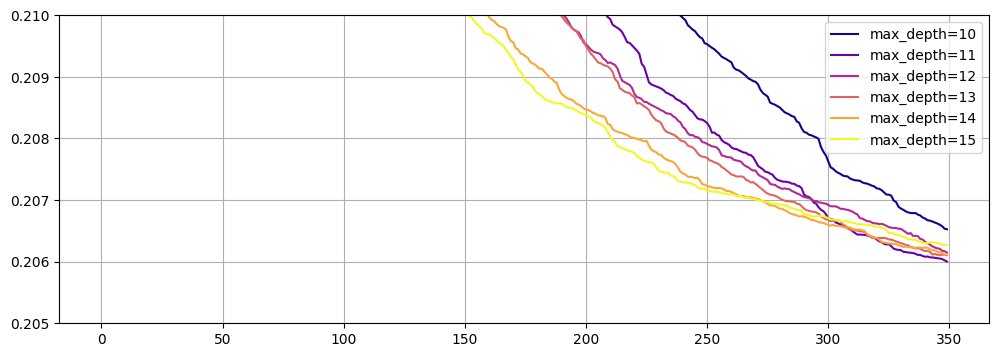

In [38]:
logs = output.stdout
scores_depth_fin = plot_scores(logs, param_name="max_depth", tuned_param=tuned_param, ylim = [0.205, 0.21])

In [45]:
%%capture output

# optimized max_depth = 12

params = {
    # "eta": 0.3,
    "n_estimators": 350,
    "max_depth": 12,
    "min_child_weight": 10,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

etas = [0.05, 0.1, 0.2, 0.3, 0.4]

tuned_param = etas

training_metrics = []

for p in tqdm(tuned_param):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=XGBRegressor, eta=p, **params)
    
    training_metrics.append(scores)

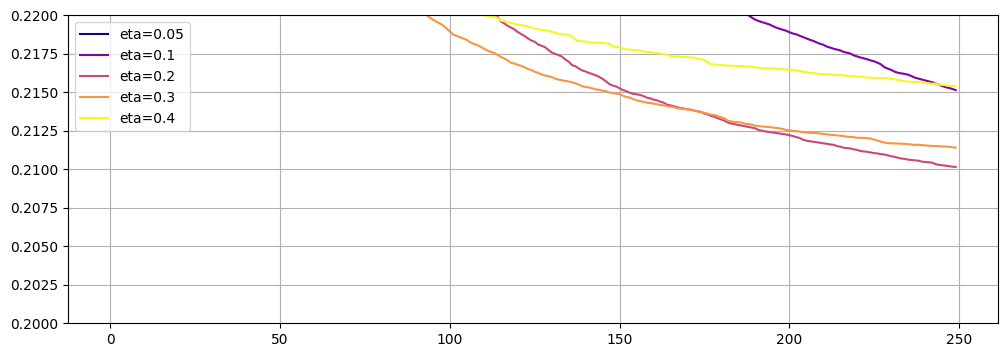

In [53]:
logs = output.stdout
scores_eta = plot_scores(logs, param_name="eta", tuned_param=tuned_param, ylim = [0.20, 0.22])

In [57]:
%%capture output

# optimized learning_rate = 0.2

params = {
    "eta": 0.2,
    "n_estimators": 250,
    "max_depth": 12,
    # "min_child_weight": 1,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

min_child_weight = [1, 2, 3, 4, 5, 6, 7, 8]

tuned_param = min_child_weight

training_metrics = []

for p in tqdm(tuned_param):
    scores = {}
    scores["params"], scores["rmse"], scores["mape"], scores["mae"] = train_linear_model(df, model=XGBRegressor, min_child_weight=p, **params)
    
    training_metrics.append(scores)

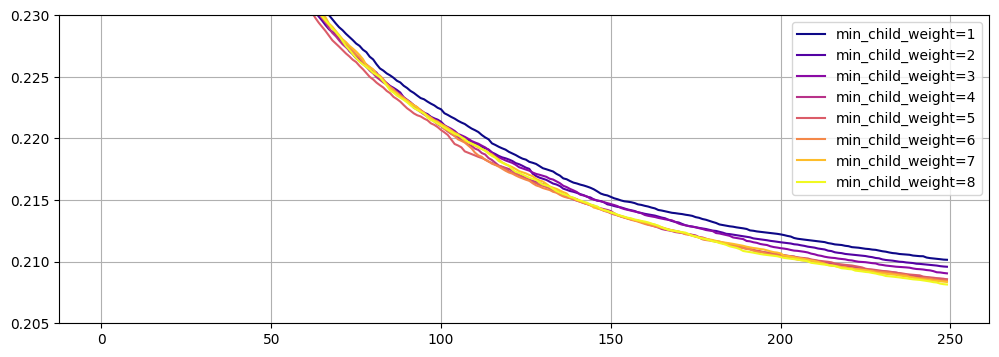

In [71]:
logs = output.stdout
scores_child = plot_scores(logs, param_name="min_child_weight", tuned_param=tuned_param, ylim = [0.205, 0.23])

In [83]:
scores_child[8]

,n_iter,train-rmse,valid-rmse
0,0,7.024676,7.024750
1,1,5.625446,5.625534
2,2,4.506610,4.506758
3,3,3.612302,3.612496
4,4,2.897736,2.898106
...,...,...,...
245,245,0.173296,0.208338
246,246,0.173216,0.208308
247,247,0.173070,0.208222
248,248,0.172932,0.208174


In [39]:
#Best XGBRegressor model

params = {
    "eta": 0.2,
    "n_estimators": 350,
    "max_depth": 12,
    "min_child_weight": 8,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"

}

model = XGBRegressor

df_full_train = df.copy()
y_full_train = df_full_train.pop("sellingprice")

numerical_features = df_full_train.select_dtypes("number").columns.to_list()

ordinal = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=-1)

df_full_train["seller"] = ordinal.fit_transform(df_full_train["seller"].values.reshape(-1,1))

scaler = StandardScaler()

df_full_train[numerical_features + ["seller"]] = scaler.fit_transform(df_full_train[numerical_features + ["seller"]])

dict_full_train = df_full_train.to_dict(orient="records")
               
dv = DictVectorizer(sparse=True)
X_full_train = dv.fit_transform(dict_full_train)

regressor = model(**params)

regressor.fit(X_full_train, y_full_train)

In [44]:
y_predict = regressor.predict(X_full_train)

print("XGBRegressor: RMSE on full_train dataset", mean_squared_error(y_predict, y_full_train, squared=False).round(4))

XGBRegressor: RMSE on full_train dataset 0.1648


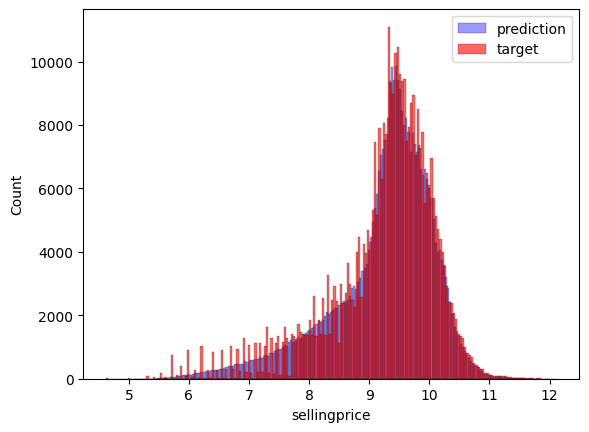

In [50]:
sns.histplot(y_predict, bins=200, color='b', alpha=0.4, label="prediction")
sns.histplot(y_full_train, bins=200, color='r', alpha=0.6, label="target")

plt.legend()
plt.show()

### Conclusion
XGBRegressor with followint parameters provides the best performance on cross validated full train dataset and I will use this model for further deployment

params = {
    "eta": 0.2,
    "n_estimators": 350,
    "max_depth": 12,
    "min_child_weight": 8,
    "nthread": -1,

    "objective": "reg:squarederror",
    "eval_metric": "rmse"
}

In [52]:
# Lets check performance on test dataset part

test_data = pd.read_csv("./dataset/car_prices_test.csv", sep=',', header='infer')

df_test = data_preprocession(test_data, features=features)
y_test = df_test.pop("sellingprice")

numerical_features = df_test.select_dtypes("number").columns.to_list()

df_test["seller"] = ordinal.transform(df_test["seller"].values.reshape(-1,1))
df_test[numerical_features + ["seller"]] = scaler.transform(df_test[numerical_features + ["seller"]])

dict_df_test = df_test.to_dict(orient="records")

X_test = dv.transform(dict_df_test)

XGBRegressor: RMSE on full_train dataset 0.203262


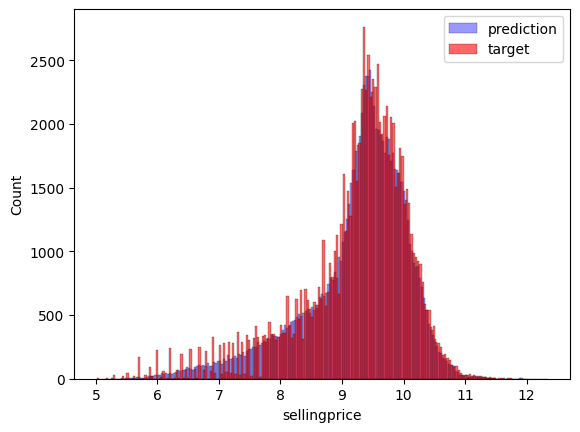

In [54]:
# XGBResressor
y_test_predict = regressor.predict(X_test)
print("XGBRegressor: RMSE on full_train dataset", mean_squared_error(y_test, y_test_predict, squared=False).round(6))

sns.histplot(y_test_predict, bins=200, color='b', alpha=0.4, label="prediction")
sns.histplot(y_test, bins=200, color='r', alpha=0.6, label="target")

plt.legend()
plt.show()

Ridge: RMSE on full_train dataset 0.265995


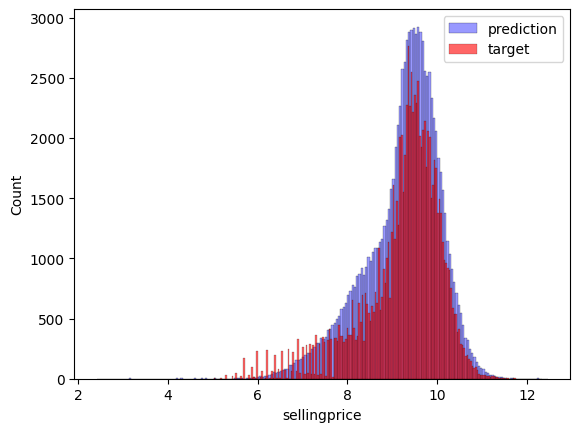

In [56]:
# Linear Regression Ridge
y_test_predict = best_lin_reg.predict(X_test)
print("Ridge: RMSE on full_train dataset", mean_squared_error(y_test, y_test_predict, squared=False).round(6))

sns.histplot(y_test_predict, bins=200, color='b', alpha=0.4, label="prediction")
sns.histplot(y_test, bins=200, color='r', alpha=0.6, label="target")

plt.legend()
plt.show()

#### Creating Test record

In [62]:
import json

print(json.dumps(test_data.iloc[199].to_dict(), indent=2))

{
  "year": 2014,
  "make": "Ram",
  "model": "2500",
  "trim": "Laramie",
  "body": "Crew Cab",
  "transmission": "automatic",
  "vin": "3c6ur5fl7eg293685",
  "state": "ut",
  "condition": 3.5,
  "odometer": 26499.0,
  "color": "black",
  "interior": "black",
  "seller": "barco rent a truck",
  "mmr": 43300,
  "sellingprice": 43000,
  "saledate": "Wed Feb 25 2015 03:30:00 GMT-0800 (PST)"
}
